In [172]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import scipy.io as sio 
import scipy
from scipy import stats
from scipy.stats import norm # normal distribution
from scipy import optimize

import matplotlib
import matplotlib.pyplot as plt

import math
import os
import random

In [162]:
# read paths
directory = os.listdir('../chip02/p655')
directory.sort()
print('../chip02/p655/' + directory[0])

../chip02/p655/180518_ch02v050r02d3_int44_time10000.mat


In [163]:
# read binary data
data = []
for k, v in enumerate(directory):
    data.append(sio.loadmat('../chip02/p655/' + directory[k]))

In [164]:
# prepare lists
fmax_ary = []
dfof_ary = []
wid_data = []
wid_pp = []
rtn_pp = []
rtn_pp_arr = []
df = []
for k, v in enumerate(data):
    fmax_ary.append(np.array([]))
    dfof_ary.append(np.array([]))

In [165]:
# Extract WID and RTN data
for k, v in enumerate(data):
    dfof_ary[k] = pd.DataFrame(columns=['slot_num', 'delta_f'])
    for key, value in data[k].items():
        if key[0] == '_':
            continue
        fmax_ary[k] = np.append(fmax_ary[k], value.max())
        dfof_ary[k].loc[key] = [round(int(key.replace('s', ''))), (value.max() - value.min()) / value.max()]
    wid_data.append((fmax_ary[k] - fmax_ary[k].mean()) / fmax_ary[k].mean() * 100)
    wid_pp.append(stats.probplot(wid_data[k]))
    # wid_pp.append(stats.probplot(fmax_ary[k]))
    dfof_ary[k] = dfof_ary[k].sort_values('delta_f')
    dfof_ary[k]['y'] = stats.probplot(dfof_ary[k]['delta_f'])[0][0].tolist()
    dfof_ary[k]['x'] = stats.probplot(dfof_ary[k]['delta_f'])[0][1].tolist()
#     print(np.corrcoef(wid_data[k], dfof_ary[k]))

# 最小二乗法を用いて近似式を導出

In [166]:
def fit_func(parameter,x,y):
    a=parameter[0]
    b=parameter[1]
    residual=y-(a*x+b)
    return residual

parameter0=[-6,-4]

In [211]:
least_squares_arr =[]
for k, v in enumerate(data):
    x_arr = np.log(dfof_ary[k]['x'].values)
    y_arr = dfof_ary[k]['y'].values
    result = scipy.optimize.leastsq(fit_func,parameter0,args=(x_arr,y_arr))[0].tolist()
    
    # y = a * log(x) + b を x = 変換
    result.append(1/ result[0])
    result.append(-result[1]/result[0]) 
    
    # 近似直線用の2点    
    result.append(min(dfof_ary[k]['y']))
    result.append(max(dfof_ary[k]['y']))
    
    result.append(math.exp(min(dfof_ary[k]['y'])*result[2] + result[3]))
    result.append(math.exp(max(dfof_ary[k]['y'])*result[2] + result[3]))
    
    least_squares_arr.append(result)
df = pd.DataFrame(least_squares_arr, 
                                  index=['N=140', 'N=280', 'N=560', 'N=1120', 'N=2240'],
                                  columns=['a', 'b', r'$\sigma$', r'$\mu$', 'y_min', 'y_max', 'x_min', 'x_max'])
df

,a,b,$\sigma$,$\mu$,y_min,y_max,x_min,x_max
N=140,3.319282,13.013758,0.301270,-3.920654,-2.905721,2.905721,0.008262,0.047585
N=280,4.034902,17.169270,0.247837,-4.255188,-2.905721,2.905721,0.006906,0.029158
N=560,4.655244,21.432948,0.214811,-4.604043,-2.905721,2.905721,0.005363,0.018688
N=1120,5.885608,29.374513,0.169906,-4.990906,-2.905721,2.905721,0.004150,0.011140
N=2240,6.475380,34.640114,0.154431,-5.349511,-2.905721,2.905721,0.003033,0.007441


In [204]:
fig, ax = plt.subplots()
plt.title("QQ-plot for P = 655")
plt.xscale("log")
font = {'size' : 21}
matplotlib.rc('font', **font)
# x = np.arange(-0.01, 0, 0.001)
# print(x*4)
# print(math.exp(df.iloc[0,0] + df.iloc[0,1]))
# y = math.exp(df.iloc[0,0]*x + df.iloc[0,1])
# print(y)
# plt.plot(x, y)

plt.plot([df.iat[0, 6], df.iat[0, 7]], [df.iat[0, 4], df.iat[0, 5]], color='blue')
plt.plot([df.iat[1, 6], df.iat[1, 7]], [df.iat[1, 4], df.iat[1, 5]], color='red')
plt.plot([df.iat[2, 6], df.iat[2, 7]], [df.iat[2, 4], df.iat[2, 5]], color='green')
plt.plot([df.iat[3, 6], df.iat[3, 7]], [df.iat[3, 4], df.iat[3, 5]], color='orange')
plt.plot([df.iat[4, 6], df.iat[4, 7]], [df.iat[4, 4], df.iat[4, 5]], color='yellow')

dfof_ary[0].plot.scatter(x='x', y='y', s=20, label='N=140', ax=ax, color='blue',edgecolors='blue')
dfof_ary[1].plot.scatter(x='x', y='y', s=20, label='N=280', ax=ax, color='red',edgecolors='red')
dfof_ary[2].plot.scatter(x='x', y='y', s=20, label='N=560', ax=ax, color='green',edgecolors='green')
dfof_ary[3].plot.scatter(x='x', y='y', s=20, label='N=1120', ax=ax, color='orange',edgecolors='orange')
dfof_ary[4].plot.scatter(x='x', y='y', s=20, label='N=2240', ax=ax, color='yellow',edgecolors='yellow', figsize=(20,20))
plt.xlabel(r'$\Delta$' + 'F / Fmax')
plt.xlim([0.003, 0.08])
plt.ylabel("Normal theoretical quantile")
plt.legend(loc="lower right")

# annotation
for k, v in enumerate(dfof_ary):
    for index, row in dfof_ary[k].iterrows():
        ax.annotate(row['slot_num'],xy=(row['x'],row['y']),size=1, fontsize=2, color='black')

# plt.show()
plt.savefig("../images/anotation/p655.pdf")
plt.close()

# [参考]最小二乗法

In [17]:
def method_of_least_squares(x, y):
    """(docstring)
    """
    # 最小二乗法の数式:
    # y = bx + a (当記事で参考にした、東京大学出版会の『統計学入門』ではこの形)。
    # b = Σxiyi - nxbarybar / Σxi^2 - nxbar^2
    # a = ybar - bxbar

    mean_x = np.mean(x)
    mean_y = np.mean(y)
    n = len(x)

    b = (np.sum(x*y) - (n*mean_x*mean_y)) / (np.sum(x**2) - (n*mean_x**2))

    a = mean_y - b*mean_x

    return b, a

In [9]:
least_squares_arr =[]
for k, v in enumerate(data):
    x_arr = np.log10(dfof_ary[k]['x'].values)
    y_arr = dfof_ary[k]['y'].values
    least_squares_arr.append(method_of_least_squares(x_arr, y_arr))
df = pd.DataFrame(least_squares_arr, 
                                  index=['N=140', 'N=280', 'N=560', 'N=1120', 'N=2240'],
                                  columns=[r'$\sigma$', r'$\mu$'])
df

,$\sigma$,$\mu$
N=140,7.642930,13.013758
N=280,9.290706,17.169270
N=560,10.719097,21.432948
N=1120,13.552113,29.374513
N=2240,14.910113,34.640114


# none_anotation

In [166]:
# Extract WID and RTN data
for k, v in enumerate(data):    
    for key, value in data[k].items():
        if key[0] == '_':
            continue
        fmax_ary[k] = np.append(fmax_ary[k], value.max())
        dfof_ary[k] = np.append(dfof_ary[k], (value.max() - value.min()) / value.max())
    wid_data.append((fmax_ary[k] - fmax_ary[k].mean()) / fmax_ary[k].mean() * 100)
    wid_pp.append(stats.probplot(wid_data[k]))
    # wid_pp.append(stats.probplot(fmax_ary[k]))
    rtn_pp.append(stats.probplot(dfof_ary[k]))
    dfof_ary[k].sort()
    print(np.corrcoef(wid_data[k], dfof_ary[k]))
    print(np.c_[rtn_pp[k][0][1], rtn_pp[k][0][0]])
    rtn_pp_arr.append(np.c_[rtn_pp[k][0][1], rtn_pp[k][0][0]])
    df.append(pd.DataFrame(rtn_pp_arr[k]))

[[ 1.          0.12124947]
 [ 0.12124947  1.        ]]
[[ 0.01061023 -2.90572058]
 [ 0.01075161 -2.61612003]
 [ 0.01075877 -2.45268537]
 [ 0.01087644 -2.33649744]
 [ 0.01149472 -2.24526334]
 [ 0.01156659 -2.16960037]
 [ 0.01173104 -2.10463566]
 [ 0.01177709 -2.04750083]
 [ 0.0118444  -1.99635921]
 [ 0.01187337 -1.94996125]
 [ 0.01194078 -1.90741677]
 [ 0.01195188 -1.86806838]
 [ 0.01205008 -1.83141622]
 [ 0.01226748 -1.79707104]
 [ 0.01228066 -1.76472352]
 [ 0.01233054 -1.73412365]
 [ 0.01240302 -1.70506637]
 [ 0.01241685 -1.67738128]
 [ 0.01256711 -1.6509252 ]
 [ 0.01259346 -1.62557663]
 [ 0.01266036 -1.60123151]
 [ 0.01276047 -1.57780005]
 [ 0.01286168 -1.55520416]
 [ 0.0128994  -1.53337553]
 [ 0.01294087 -1.51225401]
 [ 0.01297072 -1.49178637]
 [ 0.01299208 -1.47192527]
 [ 0.01302316 -1.45262839]
 [ 0.01304883 -1.43385775]
 [ 0.01312416 -1.41557914]
 [ 0.01313192 -1.39776162]
 [ 0.01313929 -1.38037711]
 [ 0.01317688 -1.36340005]
 [ 0.01328695 -1.3468071 ]
 [ 0.01333827 -1.3305769 ]


In [182]:
130.0

130.0

# Note for shaping data
## 20180607 Kanbayashi

In [17]:
type(rtn_pp[0][1])

numpy.ndarray

In [20]:
rtn_pp[0][0].shape

(378,)

In [21]:
df = pd.DataFrame({'x':rtn_pp[0][0], 'y':rtn_pp[0][1]})

In [22]:
df

,x,y
0,-2.905721,0.008045
1,-2.616120,0.009056
2,-2.452685,0.009487
3,-2.336497,0.009493
4,-2.245263,0.009498
5,-2.169600,0.009499
6,-2.104636,0.009517
7,-2.047501,0.009822
8,-1.996359,0.009978
9,-1.949961,0.010004


In [23]:
df = pd.DataFrame({'y':rtn_pp[0][0], 'x':rtn_pp[0][1]})

In [24]:
df

,x,y
0,0.008045,-2.905721
1,0.009056,-2.616120
2,0.009487,-2.452685
3,0.009493,-2.336497
4,0.009498,-2.245263
5,0.009499,-2.169600
6,0.009517,-2.104636
7,0.009822,-2.047501
8,0.009978,-1.996359
9,0.010004,-1.949961


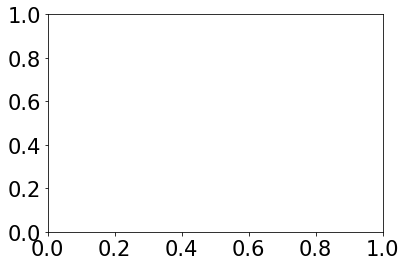

In [25]:
fig, ax = plt.subplots()

In [26]:
df.plot('x','y',kind='scatter',ax=ax)

In [27]:
for k, v in df.iterrows():
    ax.annotate(k,xy=(v['x'],v['y']),size=1)

In [29]:
plt.show()

In [31]:
%matplotlib inline

In [32]:
df.plot('x','y',kind='scatter',ax=ax)

In [33]:
plt.show()

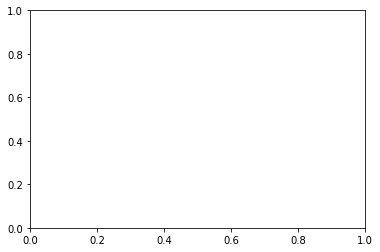

In [34]:
fig, ax = plt.subplots()

In [35]:
plt.show()

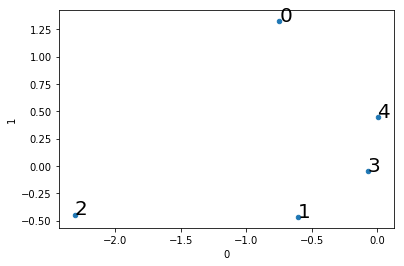

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(np.random.randn(5,2))

fig, ax = plt.subplots()
df.plot(0,1,kind='scatter',ax=ax)

for k, v in df.iterrows():
             ax.annotate(k,xy=(v[0],v[1]),size=20)

plt.show()

In [40]:
np.random.randn(5,2)

array([[ 0.32424621, -0.15262408],
       [ 0.27052373, -0.10665128],
       [ 1.56140217,  0.90540351],
       [ 0.51892174, -0.77419556],
       [ 1.26488018,  1.59061075]])

In [41]:
df = pd.DataFrame({'y':rtn_pp[0][0], 'x':rtn_pp[0][1]})

In [42]:
array = np.c_[rtn_pp[0][0], rtn_pp[0][1]]

In [44]:
array = np.c_[rtn_pp[0][1], rtn_pp[0][0]]

In [45]:
df = pd.DataFrame(array)

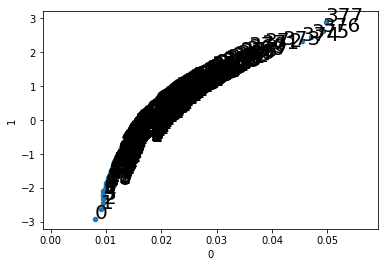

In [46]:
fig, ax = plt.subplots()
df.plot(0,1,kind='scatter',ax=ax)

for k, v in df.iterrows():
             ax.annotate(k,xy=(v[0],v[1]),size=20)

plt.show()